# Model Comparison With Finance Data
This notebook demonstrates how to run the prediction models on financial data

In [1]:
import sys
import os

# Add the project root (one level up from 'notebooks') to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Imports from our src/ modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import autocorrelation_plot

from src.data.load_fin_data import load_finance_data, load_fred_data
from src.data.preprocess_fin_data import enrich_target_stock, flatten_cols
from src.data.make_dataset import train_test_split
from src.data.split_sequences import prepare_train_val_test
from src.models.base_ARIMA import build_arima_model
from src.models.DL_LSTM import build_lstm_model, create_sequences, prepare_lstm_data, plot_predictions, evaluate_predictions

from src.evaluation.evaluate import evaluate_model
from src.evaluation.metrics import generate_model_metrics
from src.data.scaler_utils import get_scaler
from src.data.adjusted_r2 import adjusted_r2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [ ]:
# Stocks / Assets / Indices:
# TSLA – Tesla, Inc.
# BTC-USD – Bitcoin to US Dollar
# BZ=F – Brent Crude Oil Futures
# DX-Y.NYB – U.S. Dollar Index
# %5EVIX – CBOE Volatility Index (VIX)
# %5EGSPC – S&P 500 Index
# PCE Series (Personal Consumption Expenditures):
# PCEPI – PCE Price Index
# PCEPILFE – Core PCE Price Index (Excludes Food & Energy)
# Auto Production Index (FRED: A43REV) – U.S. auto production trends.
# 10-Year Treasury Yield (FRED: DGS10) – Affects growth stock valuations.
# Federal Funds Rate (FRED: FEDFUNDS) – Cost of borrowing; impacts TSLA’s financing.
# Consumer Sentiment Index (FRED: UMCSENT) – High-end car sales are sentiment-driven.
# Consumer Price Index (CPI) - FRED Code: CPIAUCSL
# Semiconductor Index - Ticker: SOXX
# Lithium Prices - Ticker: LIT

# Configuration
FRED_API_KEY = '92300a5052e3ca2facec21726fc18b04'
yahoo_series = ['BTC-USD', 'BZ=F', 'DX-Y.NYB', '%5EVIX', '%5EGSPC', 'LIT', 'SOXX']
fred_series = {'PCEPI': 'PCE_Price_Index', 'PCEPILFE': 'Core_PCE_Price_Index', 'DGS10': '10-Year_Treasury_Yield', 'FEDFUNDS': 'Federal_Funds_Rate', 'UMCSENT': 'University of Michigan: Consumer Sentiment', 'CPALTT01USM657N': 'Consumer Price Index: All Items: Total for United States', 'TOTALSA' : 'Total Vehicle Sales'}
target_ticker = 'TSLA'

scaler = get_scaler()

In [4]:
# Step 1: Load target ticker first to determine date range
df_target = load_finance_data(target_ticker, "1950-01-01", "2024-12-31")
start_date = df_target.index.min().strftime('%Y-%m-%d')
end_date = df_target.index.max().strftime('%Y-%m-%d')
print(f"Target Ticker: {target_ticker}")
print(f"Available Date Range: {start_date} to {end_date}")

# Step 2: Store target data and apply technical features
df_target = enrich_target_stock(df_target, target_ticker)
all_data = {target_ticker: df_target}

# Step 3: Load all other Yahoo Finance tickers aligned to target date range
for ticker in yahoo_series:
    if ticker == target_ticker:
        continue  # already loaded and enriched
    df = load_finance_data(ticker, start_date, end_date)
    all_data[ticker] = df

# Step 4: Load FRED macroeconomic data and align by target's date range
for series_id, series_name in fred_series.items():
    df = load_fred_data(series_id, series_name, FRED_API_KEY, start_date, end_date)
    # Clip to target's date range for clean merge
    df = df.loc[start_date:end_date]
    all_data[series_name] = df


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Target Ticker: TSLA
Available Date Range: 2010-06-29 to 2024-12-30



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Combine datasets
combined_data = None
first = True
for name, df in all_data.items():
    df = flatten_cols(df)
    if first:
        combined_data = df
        first = False
    else:
        combined_data = pd.merge(combined_data, df, left_index=True, right_index=True, how='outer')

# Flatten MultiIndex columns (if they exist)
if isinstance(combined_data.columns, pd.MultiIndex):
    combined_data.columns = ['_'.join([str(i) for i in col if i]) for col in combined_data.columns]
else:
    combined_data.columns = [str(col) for col in combined_data.columns]

# Reset and identify date column
combined_data.reset_index(inplace=True)
possible_date_cols = [col for col in combined_data.columns if 'date' in col.lower() or col.lower() == 'index']
if possible_date_cols:
    combined_data.rename(columns={possible_date_cols[0]: 'Date'}, inplace=True)
else:
    raise ValueError("Could not find a date or index column after reset_index.")

# Convert to datetime
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

# Drop NA rows before final reset/index
combined_data.dropna(inplace=True)

# Final cleanup: reset index and drop unnamed/index column if exists
combined_data.reset_index(drop=True, inplace=True)

# Now 'Date' is a proper datetime column and not an index (suitable for modeling)
# If you want it as an index for TS modeling, uncomment below:
# combined_data.set_index('Date', inplace=True)

# Clean up any leftover default index column (if exists)
if combined_data.columns[0].lower() in ['index', 'unnamed: 0']:
    combined_data.drop(columns=[combined_data.columns[0]], inplace=True)

# List all feature names
features = combined_data.columns.tolist()

# Print them out
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

# Extract the target
y = combined_data['Close_TSLA'].values.reshape(-1, 1)  # ensure 2D array

# Initialize and fit RobustScaler
target_scaler = RobustScaler()
y_scaled = target_scaler.fit_transform(y)

# Optional: add it back to the DataFrame if needed
combined_data['Close_TSLA_scaled'] = y_scaled

combined_data.to_csv('../data/dataset_finance/processed/process_finance_data.csv', index=False)    
print("Combined data saved to 'processed_finance_data.csv'")
combined_data


1. Date
2. Open_TSLA
3. High_TSLA
4. Low_TSLA
5. Close_TSLA
6. Volume_TSLA
7. TSLA_Returns
8. TSLA_hour
9. TSLA_day
10. TSLA_month
11. TSLA_weekday
12. TSLA_is_weekend
13. TSLA_RSI
14. TSLA_EMA_12
15. TSLA_EMA_26
16. TSLA_MACD
17. TSLA_MACD_Signal
18. TSLA_SMA_20
19. TSLA_SMA_50
20. TSLA_SMA_200
21. TSLA_Bollinger_Upper
22. TSLA_Bollinger_Lower
23. TSLA_Lag_1
24. TSLA_Lag_2
25. TSLA_Lag_3
26. TSLA_Lag_5
27. TSLA_Lag_10
28. TSLA_Daily_Return
29. TSLA_Total_Return_5d
30. TSLA_Total_Return_10d
31. TSLA_Total_Return_20d
32. Open_BTC-USD
33. High_BTC-USD
34. Low_BTC-USD
35. Close_BTC-USD
36. Volume_BTC-USD
37. BTC-USD_Returns
38. Open_BZ=F
39. High_BZ=F
40. Low_BZ=F
41. Close_BZ=F
42. Volume_BZ=F
43. BZ=F_Returns
44. Open_DX-Y.NYB
45. High_DX-Y.NYB
46. Low_DX-Y.NYB
47. Close_DX-Y.NYB
48. Volume_DX-Y.NYB
49. DX-Y.NYB_Returns
50. Open_%5EVIX
51. High_%5EVIX
52. Low_%5EVIX
53. Close_%5EVIX
54. Volume_%5EVIX
55. %5EVIX_Returns
56. Open_%5EGSPC
57. High_%5EGSPC
58. Low_%5EGSPC
59. Close_%5EGSPC


,Date,Open_TSLA,High_TSLA,Low_TSLA,Close_TSLA,Volume_TSLA,TSLA_Returns,TSLA_hour,TSLA_day,TSLA_month,...,Volume_SOXX,SOXX_Returns,PCE_Price_Index,Core_PCE_Price_Index,10-Year_Treasury_Yield,Federal_Funds_Rate,University of Michigan: Consumer Sentiment,Consumer Price Index: All Items: Total for United States,Total Vehicle Sales,Close_TSLA_scaled
0,2014-09-17,17.493999,17.646667,17.299999,17.425333,77665500.0,0.002454,0.0,17.0,9.0,...,444000.0,0.007184,97.413,96.013,2.62,0.09,84.6,0.075257,16.959,-0.028958
1,2014-09-18,17.557333,17.706667,17.488001,17.587999,55389000.0,0.009335,0.0,18.0,9.0,...,355500.0,0.015286,97.413,96.013,2.63,0.09,84.6,0.075257,16.959,-0.028117
2,2014-09-19,17.199333,17.428667,17.018000,17.288000,102163500.0,-0.017057,0.0,19.0,9.0,...,339000.0,-0.012491,97.413,96.013,2.59,0.09,84.6,0.075257,16.959,-0.029668
3,2014-09-22,17.000000,17.068001,16.313999,16.668667,123211500.0,-0.035824,0.0,22.0,9.0,...,315600.0,-0.012083,97.413,96.013,2.57,0.09,84.6,0.075257,16.959,-0.032871
4,2014-09-23,16.348000,16.920000,16.333332,16.694000,84880500.0,0.001520,0.0,23.0,9.0,...,632700.0,-0.003201,97.413,96.013,2.54,0.09,84.6,0.075257,16.959,-0.032740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,2024-02-26,192.289993,201.779999,192.000000,199.399994,111747100.0,0.038704,0.0,26.0,2.0,...,3759000.0,0.009867,122.494,121.418,4.28,5.33,76.9,0.618967,16.177,0.912051
2374,2024-02-27,204.039993,205.600006,198.259995,199.729996,108645400.0,0.001655,0.0,27.0,2.0,...,4560900.0,-0.000996,122.494,121.418,4.31,5.33,76.9,0.618967,16.177,0.913757
2375,2024-02-28,200.419998,205.300003,198.440002,202.039993,99806200.0,0.011566,0.0,28.0,2.0,...,2923800.0,-0.011244,122.494,121.418,4.27,5.33,76.9,0.618967,16.177,0.925703
2376,2024-02-29,204.179993,205.279999,198.449997,201.880005,85907000.0,-0.000792,0.0,29.0,2.0,...,3382800.0,0.027091,122.494,121.418,4.25,5.33,76.9,0.618967,16.177,0.924875


In [ ]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'])  # parse as datetime
combined_data.set_index('Date', inplace=True)

combined_data['Close_TSLA'].plot(figsize=(10, 5))
plt.title('Close Price of TSLA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

autocorrelation_plot(combined_data['Close_TSLA'])
plt.title('Autocorrelation of TSLA Close Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [ ]:
# ARIMA is represented by three parameters: p, d, and q:
# p: The number of past values (lags) considered in the AR term.
# d: The degree of differencing applied to the data.
# q: The number of past forecast errors included in the MA term.
# order = (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.

order = (5, 1, 0)
predictions, train, test = build_arima_model(combined_data['Close_TSLA'], order, 0.7)

# Convert to numpy arrays (in case they're lists)
test = np.array(test)
predictions = np.array(predictions)
 
rmse, mse, mae, mape, r2, adj_r2	= generate_model_metrics(predictions, test)

# Root Mean Squared Error
# rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# Mean Squared Error
# mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)

# Mean Absolute Error
# mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)

# Mean Absolute Percentage Error
# mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Test MAPE: %.3f' % mape)

# R-squared
# r2 = r2_score(test, predictions)
print('Test R²: %.3f' % r2)

# Adjusted R-squared
n = len(test)
p = 1  # number of predictors (just 1 for ARIMA by default)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('Adjusted R²: %.3f' % adj_r2)

# plot forecasts against actual outcomes
plt.plot(test, color='blue', label='Actual', linewidth=2, alpha=0.7)
plt.plot(predictions, color='red', label='Predicted', linestyle='--', linewidth=2)
plt.legend()
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend(['Actual', 'Predicted'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
metrics_scores = {}
metrics_scores[name] = {"RMSE": rmse, "MSE": mse, "MAE": mae, "MAPE": mape, "R2": r2, "Adj_R2": adj_r2}
metrics_df = pd.DataFrame(metrics_scores).T  # Transpose so models are rows
# metrics_df.to_csv("model_metrics_scores.csv")
print(metrics_df)

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(mse_scores.keys(), mse_scores.values())
plt.title("Model Comparison - MSE (Unscaled Prices)")
plt.ylabel("Mean Squared Error (USD)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(mae_scores.keys(), mae_scores.values())
plt.title("Model Comparison - MAE (Unscaled Prices)")
plt.ylabel("Mean Absolute Error (USD)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0116 - val_loss: 0.0393
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.3520e-04 - val_loss: 0.0386
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.1752e-04 - val_loss: 0.0341
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1959e-04 - val_loss: 0.0321
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8356e-04 - val_loss: 0.0324
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1247e-04 - val_loss: 0.0282
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0816e-04 - val_loss: 0.0264
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5814e-04 - val_loss: 0.0255
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3822e-04 - val_loss: 0.0237
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4594e-04 - val_loss: 0.0310
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


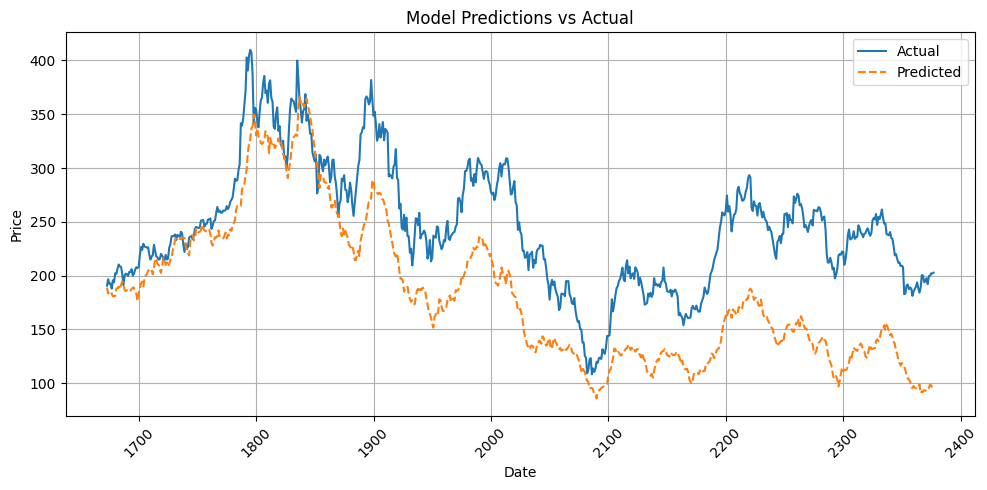

RMSE: 70.474, MAE: 61.467, R²: -0.496


In [7]:
# Step 1: Prepare your dataset
X_train, X_test, y_train, y_test, scaler, date_index = prepare_lstm_data(combined_data, "Close_TSLA", 30, 0.3)

# Step 2: Build and train the model
n_features = X_train.shape[2]
model = build_lstm_model(30, n_features=n_features)

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 3: Predict and evaluate
y_pred = model.predict(X_test)

# Determine the correct number of columns from the scaler
n_total_features = scaler.n_features_in_

# Pad predictions with zeros for inverse transform
y_pred_full = np.zeros((len(y_pred), n_total_features))
y_pred_full[:, -1] = y_pred.flatten()

y_test_full = np.zeros((len(y_test), n_total_features))
y_test_full[:, -1] = y_test.flatten()

# Inverse transform and extract only the target column
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]
y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]

# Step 4: Plot results
plot_predictions(date_index, y_test_inv, y_pred_inv)

# Step 5: Print metrics
rmse, mae, r2 = evaluate_predictions(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")